In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append("./../../samplers/")
from mcmc_uncertainty_prop import gpjaxGP

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

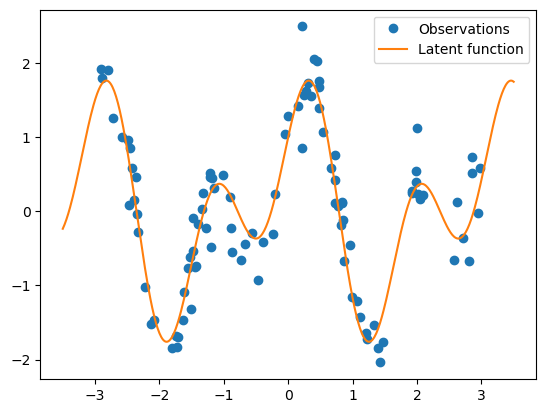

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

In [4]:
# Prior kernel
kernel = gpx.kernels.RBF()  # 1-dimensional input

# Prior mean
constant_param = gpx.parameters.Parameter(value=0.0, tag='None')
meanf = gpx.mean_functions.Constant(constant_param)

# Prior GP
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

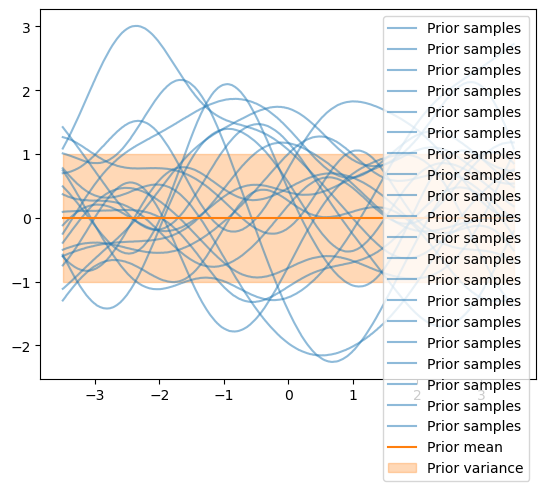

In [5]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean
prior_std = prior_dist.variance
samples = prior_dist.sample(key=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")

In [6]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [7]:
print(-gpx.objectives.conjugate_mll(posterior, D))

132.6462594200374


In [8]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
    trainable=gpx.parameters.Parameter,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization terminated successfully.
         Current function value: 55.435922
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
55.435921664319345


In [9]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

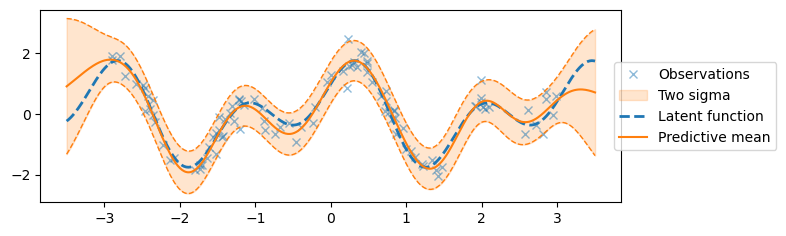

In [10]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

### Testing gpjax wrapper

In [11]:
gpwrapped = gpjaxGP(opt_posterior, D)
pred = gpwrapped(xtest)

print("Means equal:")
print(jnp.allclose(latent_dist.mean, pred.mean.flatten()))

print("Covs equal:")
print(jnp.allclose(latent_dist.covariance_matrix, pred.cov, 
                   rtol=0, atol=2*opt_posterior.jitter))


Means equal:
True
Covs equal:
True


In [ ]:
# Testing conditioning on new data
xnew = jnp.array([1.7]).reshape(-1, 1) # 2.2, 2.3, 2.4
ynew = f(xnew)
Dnew = gpx.Dataset(X=xnew, y=ynew)
Dcomb = D + Dnew

prednew_baseline = opt_posterior.predict(xtest, train_data=Dcomb)
prednew = gpwrapped(xtest, given=Dnew)

In [13]:
print("Means equal:")
print(jnp.allclose(prednew_baseline.mean, prednew.mean.flatten()))

print("Covs equal:")
print(jnp.allclose(prednew_baseline.covariance_matrix, prednew.cov, 
                   rtol=0, atol=2*opt_posterior.jitter))

Means equal:
False
Covs equal:
False


In [14]:
prednew_baseline.mean[:5]

Array([0.91026204, 0.93763597, 0.96530787, 0.99324476, 1.02141201],      dtype=float64)

In [17]:
prednew.mean.flatten()[:5]

Array([-6.35211548, -6.69809333, -7.05736646, -7.4301231 , -7.81653449],      dtype=float64)